# Imports

In [34]:
import os 
from datetime import datetime

import numpy as np

from classify import temperature
from classify.data.responses import responses_to_traffic_array
from classify.data.traffic import load_traffic
from classify.scenario.bridge import healthy_damage, transverse_crack
from classify.scenario.traffic import normal_traffic
from fem.run.opensees import OSRunner
from model.bridge import Point
from model.bridge.bridge_705 import bridge_705_3d, bridge_705_med_config
from model.response import ResponseType
from plot import plt
from util import resize_units

In [35]:
c = bridge_705_med_config(bridge_705_3d)
original_c = c
# Set the directory of where to save/load responses.
c.root_generated_data_dir = os.path.join("/Users/jeremy/Desktop/mesh-med-600", c.root_generated_data_dir)
c.root_generated_data_dir

INFO: Loaded vehicle data from /Users/jeremy/cs/bridge-dss/data/a16-data/a16.csv in 0.10s
WARN: Vehicle PDF sums to 99.5, adjusted to sum to 1


'/Users/jeremy/Desktop/mesh-med-600/generated-data'

# Response type aliases

In [36]:
# Short aliases for response types.
rt_y = ResponseType.YTranslation
rt_s = ResponseType.Strain

# Create functions to resize, and unit strings, for each response type.
resize_y, units_y = resize_units(rt_y.units())
resize_s, _ = resize_units(rt_s.units())

# Temperature data

In [37]:
# Load minute-by-minute temperature data for the year.
from_ = datetime.fromisoformat(f"2019-01-01T00:00")
to = datetime.fromisoformat(f"2019-12-31T23:59")
temps_year = temperature.from_to_mins(temperature.load("holly-springs"), from_, to)
temps_year["temp"] = temperature.resize(temps_year["temp"])

# Traffic data

In [38]:
total_mins = 2
total_seconds = total_mins * 60
traffic_scenario = normal_traffic(c=c, lam=5, min_d=2)
traffic_sequence, traffic, traffic_array = load_traffic(
    c=c,
    traffic_scenario=traffic_scenario,
    max_time=total_seconds,
)
traffic_array.shape

/Users/jeremy/Desktop/mesh-med-600/generated-data/bridge-705-3d/healthy/traffic/normal-lam-5-600-120-0,01.npy
INFO: Vehicle PDF groups loaded in 0.3168742299999394
Trafic warmed up at = 9.877365504654566
max_time = 129.87736550465456
INFO: Generated 129.924 - 9.877 = 120.046 s of 'TrafficSequence'
warmed up at = 9.877365504654566
INFO: Converting 'TrafficSequence' to 'TrafficArray'
Vehicle entered 0 at t = 0.000, sum = 1 0.0000 s
Vehicle entered 1 at t = 0.000, sum = 1
Vehicle entered 0 at t = 1.040, sum = 2 1.0000 s
Vehicle entered 1 at t = 1.200, sum = 2
Vehicle entered 0 at t = 1.970, sum = 3
Vehicle entered 1 at t = 3.100, sum = 3 3.0100 s
Vehicle entered 0 at t = 3.440, sum = 4
Vehicle entered 1 at t = 4.310, sum = 4 4.0200 s
Vehicle entered 0 at t = 4.480, sum = 5
Vehicle entered 0 at t = 5.260, sum = 6 5.0300 s
Vehicle entered 1 at t = 5.710, sum = 5
Vehicle entered 1 at t = 7.640, sum = 6 7.0500 s
Vehicle entered 0 at t = 7.690, sum = 7
Vehicle entered 1 at t = 8.490, sum = 7 8

(12001, 2400)

# Collect time series of responses

In [22]:
response_types = [rt_y]
sensor_point = Point(x=51.8, y=0, z=-8.4)
# Split the traffic array in half, the crack will happen halfway through.
half_i = int(len(traffic_array) / 2)
traffic_array_0, traffic_array_1 = traffic_array[:half_i], traffic_array[half_i:]
assert len(traffic_array_0) + len(traffic_array_1) == len(traffic_array)

responses = []
for rt in response_types:
    responses_healthy_cracked = []
    for ds, ta in [(healthy_damage, traffic_array_0), (transverse_crack(), traffic_array_0)]:
        print(f"Sections in damage scenario = {len(ds.use(c)[0].bridge.sections)}")
        responses_healthy_cracked.append(responses_to_traffic_array(
            c=c, traffic_array=ta, response_type=rt, damage_scenario=ds, points=[sensor_point],
        ).T[0])  # Responses from a single point.
    responses.append(np.concatenate(responses_healthy_cracked))
responses = np.array(responses)
responses.shape

Sections in damage scenario = 25
(6000, 2400)
(2400, 1)
Sections in damage scenario = 38
(6000, 2400)
(2400, 1)


(1, 12000)

# Time series of cracked responses

INFO: Saving image to /Users/jeremy/Desktop/mesh-med-600/generated-data-images/bridge-705-med-3d/healthy/classify/cracked/crack-time-series.pdf


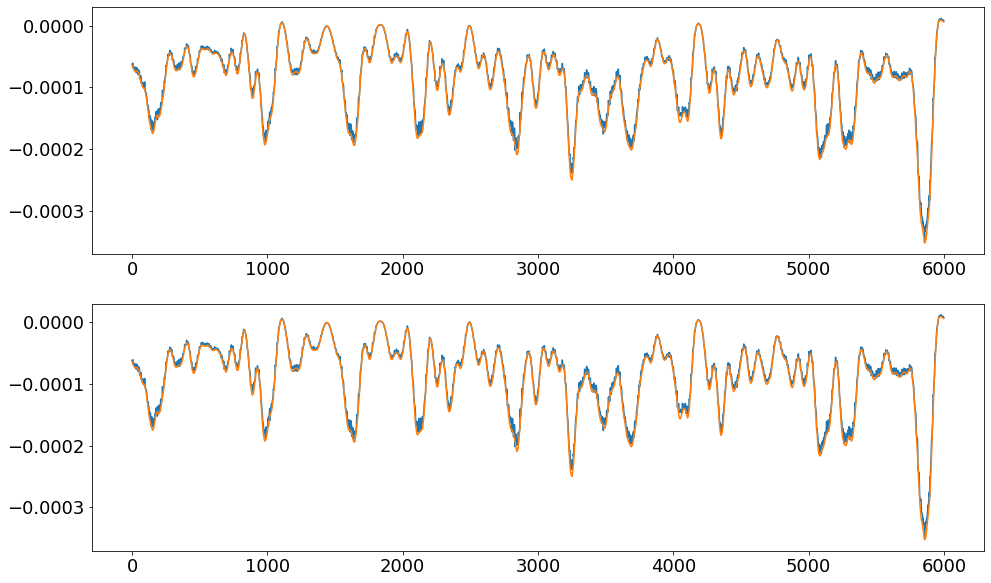

In [39]:
plt.landscape()
plt.subplot(2, 1, 1)
plt.plot(np.arange(half_i), responses[0][:half_i])
plt.plot(np.arange(half_i), responses[0][half_i:])
# plt.plot(np.arange(half_i, len(responses[0])), responses[0][half_i:])
plt.subplot(2, 1, 2)
plt.plot(np.arange(half_i), responses[0][:half_i])
plt.plot(np.arange(half_i), responses[0][half_i:])
# plt.plot(np.arange(half_i, len(responses[1])), responses[1][half_i:])
plt.savefig(c.get_image_path("classify/cracked", "crack-time-series.pdf"))